# AI03b TP2

# Practical work on spectral estimation

## Alexandre MALLEZ 

---

## PARTIE 1

### Q1)

In [184]:
import matplotlib.pyplot as plt
import numpy as np

In [185]:
from scipy.signal import lfilter

def generate_ar_process(ar_coeffs, sigma2, N):
    
    noise = np.random.normal(0, np.sqrt(sigma2), N) 
    ar_coeffs=[-i for i in ar_coeffs]
    ar_coeffs_full = [1] + ar_coeffs # Convert to full AR representation
    
    # Use lfilter to apply the AR filter to the noise
    ar_process = lfilter([1], ar_coeffs_full, noise)
    
    return ar_process



In [346]:
ar_coeffs = [0.75, -0.25]  # Example AR(2) process coefficients
sigma2 = 1.0  # Innovation variance
N = 1000  # Length of the signal
ar_signal = generate_ar_process(ar_coeffs, sigma2, N)

print(ar_signal[:10]) 

[ 0.29927893  1.46934405  1.20193633 -0.40250017 -1.33410267 -2.099926
  0.74604599 -0.44860702  0.94472776  1.72125149]


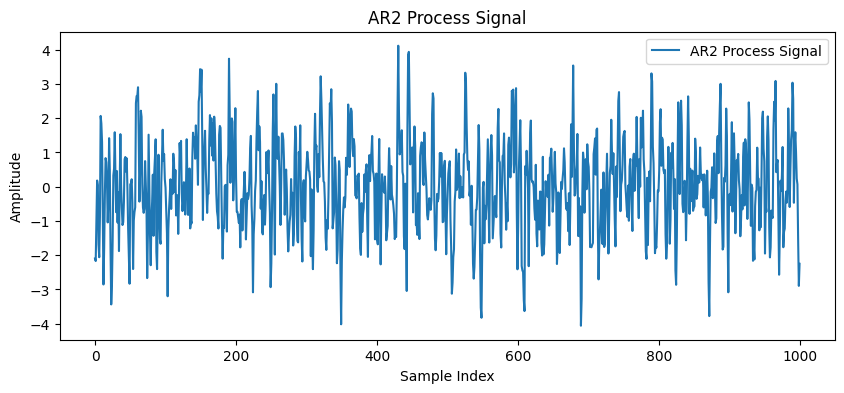

In [187]:
def show_signal(signal, title='Signal'):
    plt.figure(figsize=(10, 4))
    plt.plot(signal, label=title)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
show_signal(ar_signal, 'AR2 Process Signal')

---

### Q2)

In [383]:
def compute_periodogramm(signal,nu,methods,L=8,overlap=0.5):
    N=len(signal)

    if methods=='standard':
        periodogram = 0
        for t in range(N):
            periodogram += signal[t]*np.exp(-2j*np.pi*t*nu)
        periodogram = np.abs(periodogram)**2/N
        return periodogram

    elif methods=='bartlett':
        M = N // L
        periodogram = 0
        for i in range(L):
            segment = signal[i * M : (i + 1) * M]  
            sous_periodogram = np.sum(segment * np.exp(-2j * np.pi * nu * np.arange(M))) 
            periodogram += np.abs(sous_periodogram) ** 2 / M 
        periodogram /= L  
        return periodogram

    elif methods=='welch':
        M = N // L  
        step = int(M * (1 - overlap)) 
        window = np.hanning(M)  

        periodogram = 0
        num_segments = 0  
    
        for start in range(0, N - M + 1, step): 
            segment = signal[start : start + M] * window
            sous_periodogram = np.sum(segment * np.exp(-2j * np.pi * nu * np.arange(M))) 
            periodogram += np.abs(sous_periodogram) ** 2 / M 
            num_segments += 1 

        periodogram /= num_segments  
        periodogram /= np.sum(window)/(M) #normalization

        return periodogram
    
    else:
        print('Method not recognized')
        return None

In [200]:
def show_periodogram(signal,methods,L=8,overlap=0.5):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)  
    if methods=='all':
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        methodss=['standard','bartlett','welch']
        for nu in nus:
            for methods in methodss:
                periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
        plt.figure(figsize=(10, 4))
        for methods in methodss:
            plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
        plt.title(f'Periodogram of AR Process Signal with 3 methods')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()
        plt.show()

    else : 
    
        periodogram=[]
        for nu in nus:
            periodogram.append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))

        plt.figure(figsize=(10, 4))
        plt.plot(nus, periodogram, label=f'Periodogram ({methods})')
        plt.title(f'Periodogram of AR Process Signal ({methods})')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()
        plt.show()


In [190]:
show_periodogram(ar_signal,'standard')
# show_periodogram(ar_signal,'bartlett')
# show_periodogram(ar_signal,'welch')

---


### Q3)

In [409]:
def ar_psd(ar_coeffs, sigma2, nu):

    p = len(ar_coeffs)
    numerator = sigma2
    denominator = np.abs(1 - np.sum([ar_coeffs[i] * np.exp(-2j * np.pi * nu * (i+1)) for i in range(p)], axis=0))**2
    return numerator / denominator

def show_periodogram_ar(signal,methods,L=8,overlap=0.5,ar_coeffs=None):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)  
    if methods=='all':
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        methodss=['standard','bartlett','welch']
        psd=[]
        for nu in nus:
            for methods in methodss:
                periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
            psd.append(10*np.log(ar_psd(ar_coeffs, sigma2, nu)))
        plt.figure(figsize=(10, 4))
        for methods in methodss:
            plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
        plt.plot(nus, psd, label='AR PSD', color='black', linestyle='--')
        plt.title('Periodogram and theoretical PSD')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.ylim(-60, 30)
        plt.grid()
        plt.legend()
        plt.show()

In [385]:
ar_coeffs=[0.5] # Example AR(1) process coefficients
ar_signal2 = generate_ar_process(ar_coeffs, sigma2, N)

show_signal(ar_signal2, 'AR1 Process Signal')
show_periodogram_ar(ar_signal2,'all',L=8,overlap=0.5,ar_coeffs=ar_coeffs)

---

### Q4)

In [440]:
import tqdm
N=200
n=100
methodss=['standard','bartlett','welch']

def bias_calculator(ar_coeffs,nu,n):
    periodogram={'standard':[],'bartlett':[],'welch':[]}
    for _ in range(n):
        ar_signal = generate_ar_process(ar_coeffs, sigma2, N)
        for methods in methodss:
            periodogram[methods].append(compute_periodogramm(ar_signal,nu,methods))
    V=[]
    for methods in methodss:
        V.append(np.mean(periodogram[methods]))
    return V

def bias_graph(ar_coeffs,n):
    nus=np.linspace(0, 0.5, n)
    periodogram={'standard':[],'bartlett':[],'welch':[]}

    for nu in tqdm.tqdm(nus):
        for i in range(len(methodss)):
            periodogram[methodss[i]].append(bias_calculator(ar_coeffs,nu,n)[i] - ar_psd(ar_coeffs,sigma2,nu))

    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus,periodogram[methods], label=f'Bias ({methods})')
    plt.title('Bias of Periodogram with 3 methods')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

def var_calculator(ar_coeffs,nu,n):
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        for _ in range(n):
            ar_signal = generate_ar_process(ar_coeffs, sigma2, N)
            for methods in methodss:
                periodogram[methods].append(compute_periodogramm(ar_signal,nu,methods) - ar_psd(ar_coeffs,sigma2,nu))
        V=[]
        for methods in methodss:
            V.append(np.var(periodogram[methods]))
        return V
    
def var_graph(ar_coeffs,n):
    nus=np.linspace(0, 0.5, n)
    periodogram={'standard':[],'bartlett':[],'welch':[]}
    for nu in tqdm.tqdm(nus):
        for i in range(len(methodss)):
            periodogram[methodss[i]].append(var_calculator(ar_coeffs,nu,n)[i])
    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus,periodogram[methods], label=f'Variance ({methods})')
    plt.title('Variance of Periodogram with 3 methods')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()
    

    

Remarque : on pourrait largement optimiser ces fonctions mais par souci de temps je laisse laisse comme c'est actuellement (le problème actuel est qu'on calcul le periodogramme pour chaque fréquence à chaque fois, ce qui n'est pas utile)

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


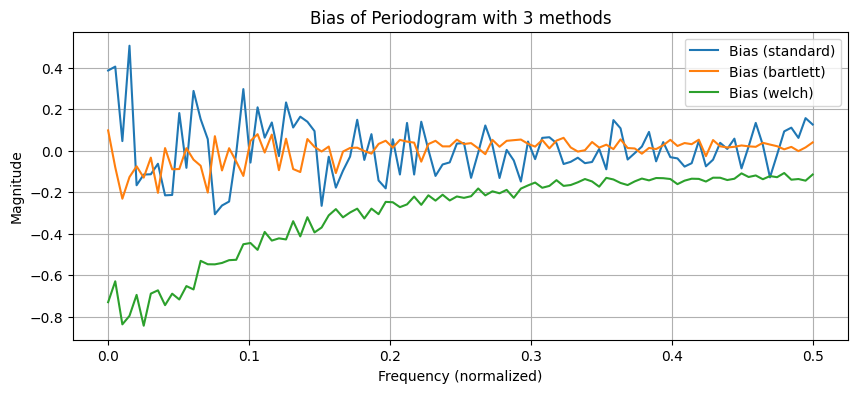

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


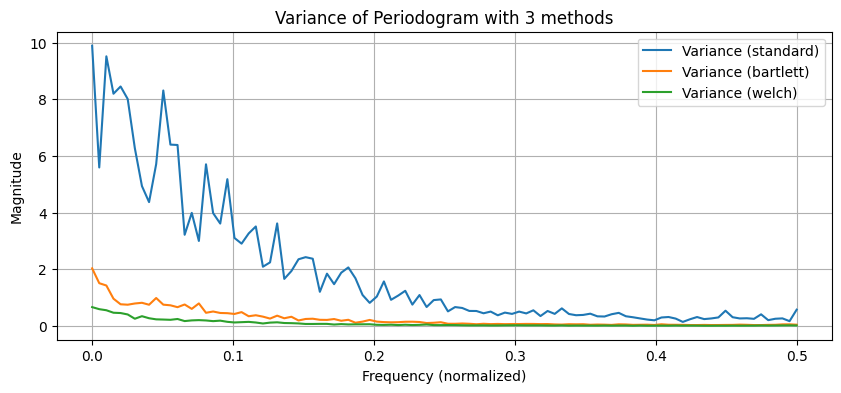

In [441]:
bias_graph(ar_coeffs,n)
var_graph(ar_coeffs,n)
N=1000 #on remet la bonne valeur de N

Il y a sûrement un leger problème de normalisation pour Welch mais les courbes sont stables et les variances et biais sont cohérents avec l'utilisation des estimateurs et la complexité de ceux-ci (Welsh, la méthode la plus dévelopé à la meilleure variance et un biais moyen qui sont tout 2 plus stable, alors que le periodogramme est bien plus instable).

---

### Q5)

In [195]:
import librosa

ar_coeffs_estimate = librosa.lpc(ar_signal2, order=1)

print("Coefficients AR estimés:", ar_coeffs_estimate)



Coefficients AR estimés: [ 1.         -0.48339203]


---

### Q6)

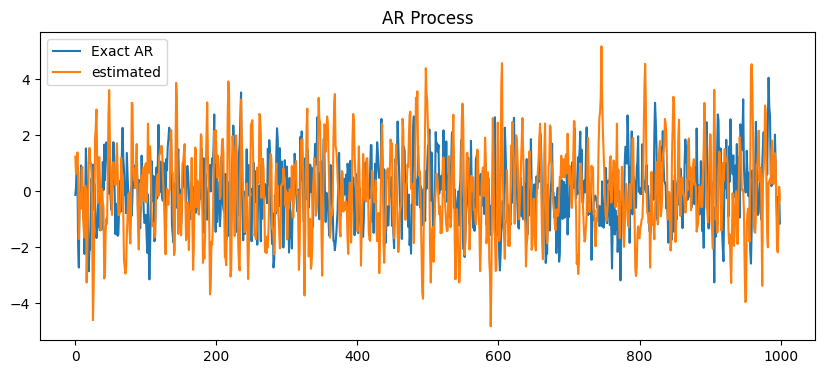

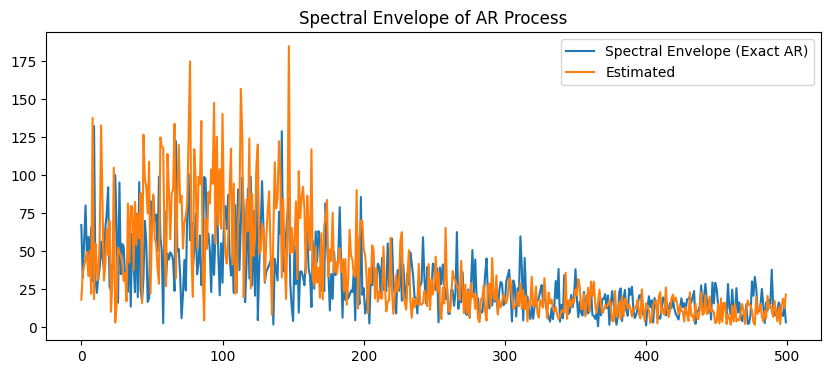

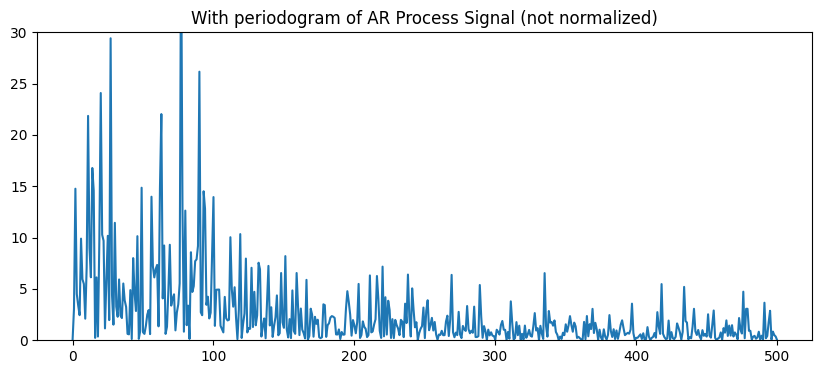

In [627]:
from scipy.signal import periodogram

ar_signal_estimate = generate_ar_process(ar_coeffs_estimate, sigma2, N)
plt.figure(figsize=(10, 4))
plt.plot(ar_signal2, label='Exact AR')
plt.plot(ar_signal_estimate, label='estimated')
plt.legend()
plt.title('AR Process')
plt.show()

fft_signal = np.fft.fft(ar_signal)


envelope_spectral = np.abs(fft_signal)

plt.figure(figsize=(10, 4))
plt.plot(envelope_spectral[0:500], label='Spectral Envelope (Exact AR)')
plt.plot(np.abs(np.fft.fft(ar_signal_estimate))[0:500], label='Estimated')
plt.legend()
plt.title('Spectral Envelope of AR Process')
plt.show()

frequencies, Pxx = periodogram(ar_signal2)

plt.figure(figsize=(10, 4))
plt.plot( Pxx)
plt.title('With periodogram of AR Process Signal (not normalized)')
plt.ylim(-0, 30)
plt.show()

La courbe théorique et celle estimé sont proches, ainsi l'estimation d'un AR1 est bonne (cependant ce n'est qu'un AR1 donc il ya une très bonne précision, ce qui est attendu). La courbe du periodogramme a la même tendance que la théorie, mais n'est quand même en géneral pas très précis. 

---

### Q7)

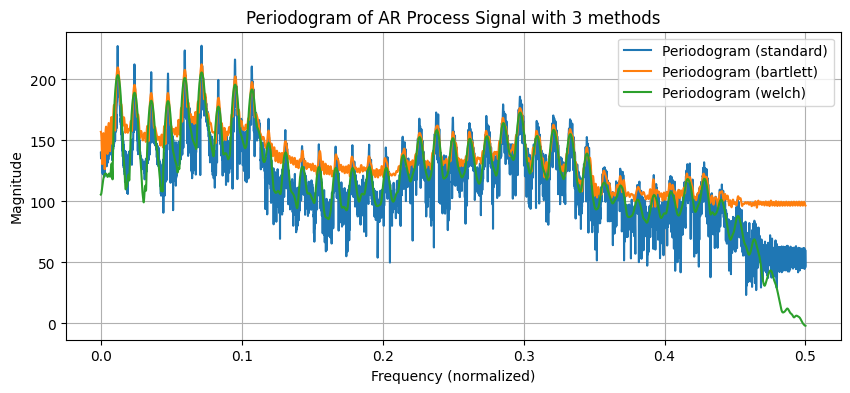

In [389]:
from scipy.io import wavfile

fs, data = wavfile.read("sounds/aeiou.wav")

start_time = 0.2  # en secondes
duration = 0.4  # en secondes
start_sample = int(start_time * fs)
end_sample = int((start_time + duration) * fs)
segment_a = data[start_sample:end_sample]

show_periodogram(segment_a,'all')


On voit qu'en voulant trop lissé, la méthode bartlett s'écarte des valeurs réels (car il y a beaucoup plus de pic aussi), cependant le periodogramme standard et de welch ont à peu près la même forme (bien que le periodogramme soit un peu plus instable)

---
---

# PARTIE 2 :

### Q1)

In [390]:
def synthetise_signal(N,K,frequencies, amplitudes, phases,sigma2):
    t = np.arange(N)
    signal = np.zeros(N)
    
    for i in range(K):
        signal += amplitudes[i] * np.cos(2 * np.pi * frequencies[i] * t + phases[i])
    
    noise = np.random.normal(0, np.sqrt(sigma2), N) #bruit gaussien
    signal += noise
    
    return signal


---


### Q2)

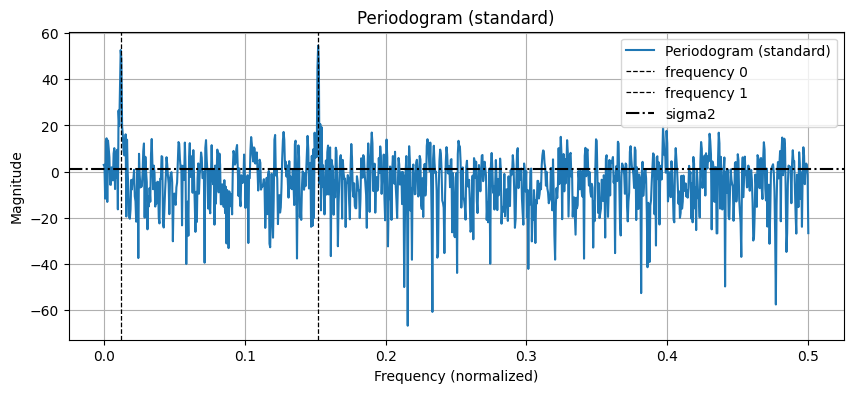

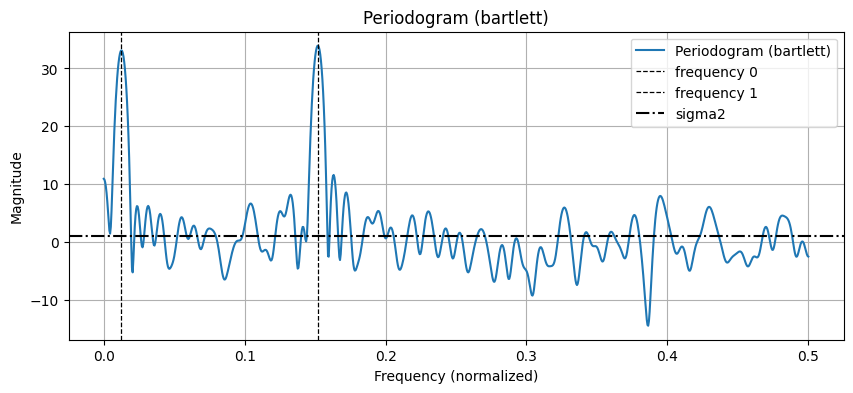

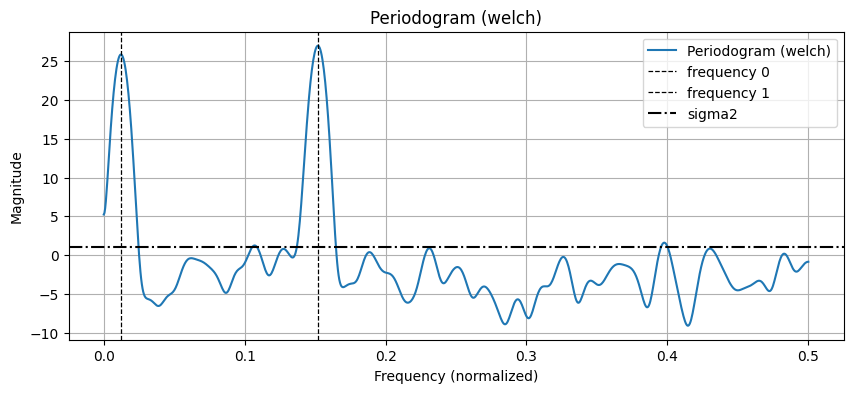

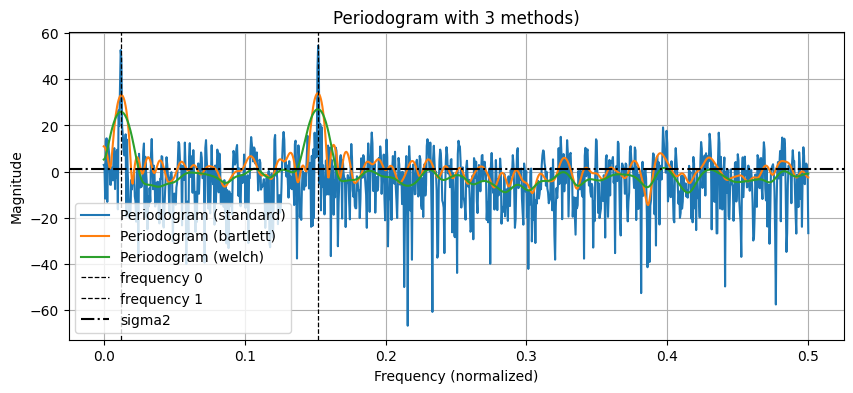

In [391]:
K=2
frequencies=np.random.rand(2,1)/2 #frequence nu1 et nu2 aléatoires entre 0 et 0.5
amplitudes=[1,1]
phases=[0,0]
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)

#reprise de la fonction de la partie 1 en ajoutant l'affichage des fréquences
def show_periodograms(signal,frequencies=[],L=8,overlap=0.5):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)  
    periodogram={'standard':[],'bartlett':[],'welch':[]}
    methodss=['standard','bartlett','welch']
    for methods in methodss:
        for nu in nus:
            periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
        plt.figure(figsize=(10, 4))
        plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
        for i in range(len(frequencies)):
            plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
        plt.axhline(sigma2, color='black', linestyle='-.', label='sigma2')
        plt.title(f'Periodogram ({methods})')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()
        plt.show()
    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
    for i in range(len(frequencies)):
        plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
    plt.axhline(sigma2, color='black', linestyle='-.', label='sigma2')
    plt.title(f'Periodogram with 3 methods)')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

show_periodograms(signal,frequencies)

---

### Q3)

SNR élevé :

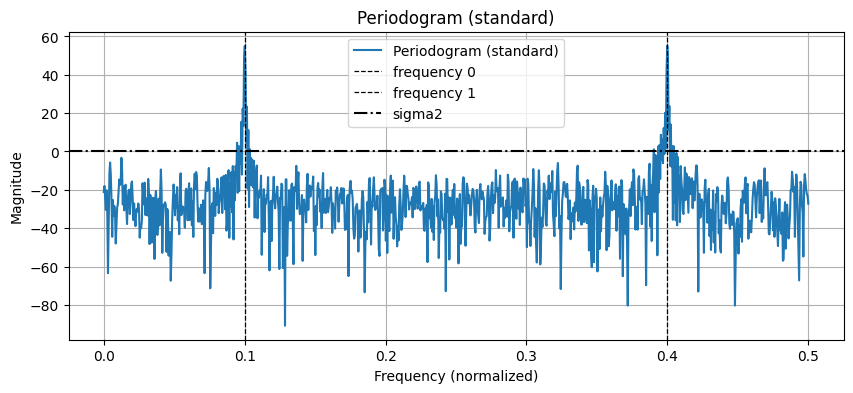

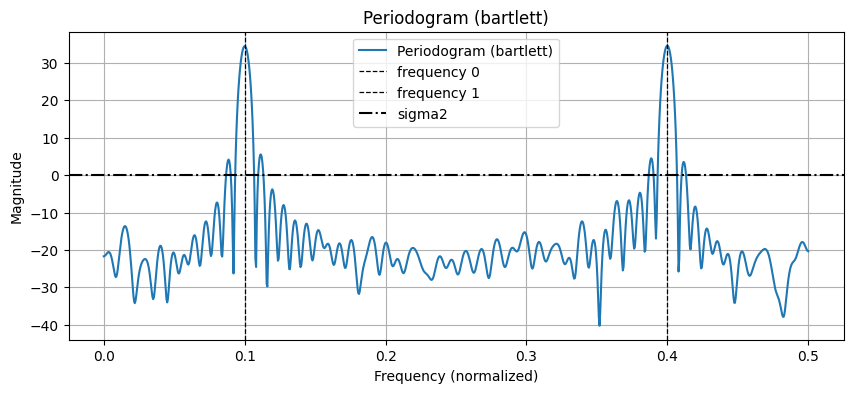

In [392]:
frequencies=[0.1,0.4]
sigma2=0.1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms(signal,frequencies)

SNR faible

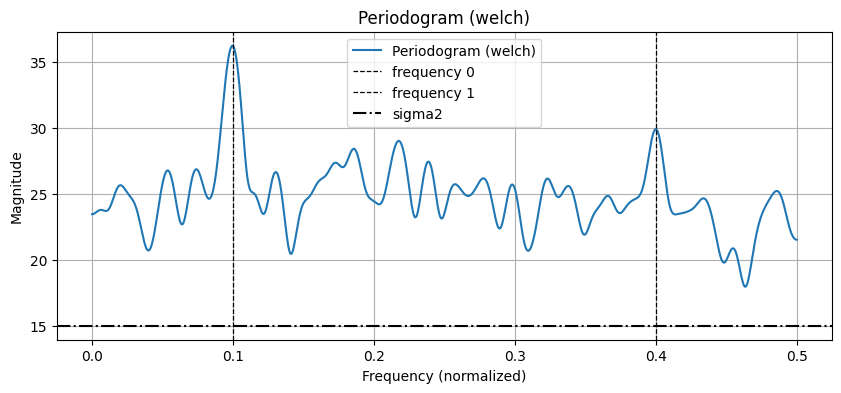

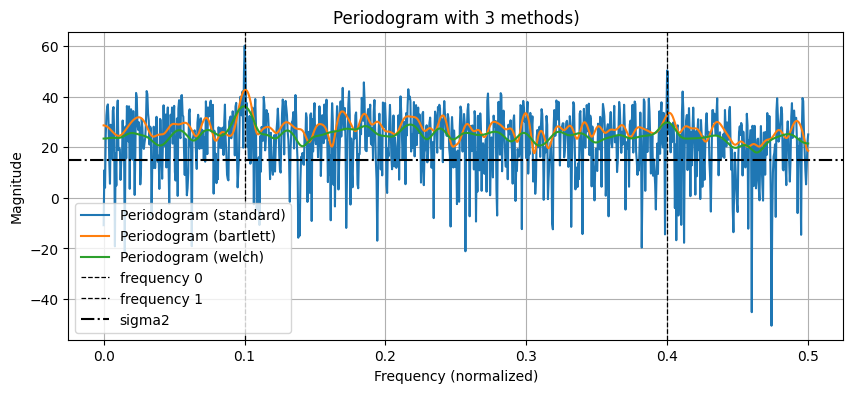

In [393]:
frequencies=[0.1,0.4]
sigma2=15
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms(signal,frequencies)

Fréquences proches

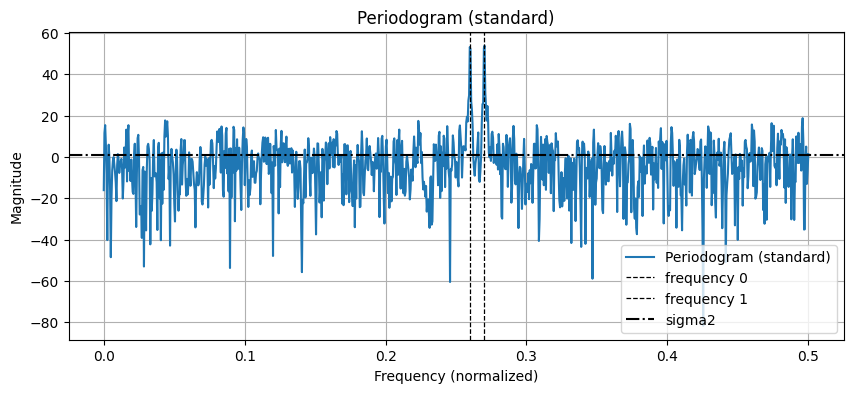

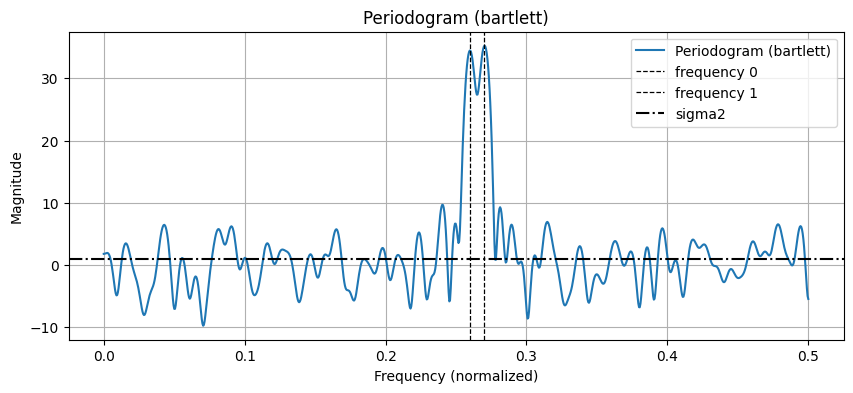

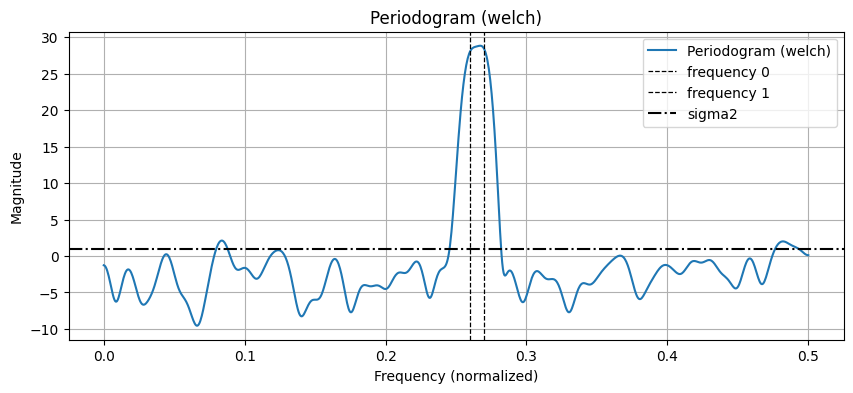

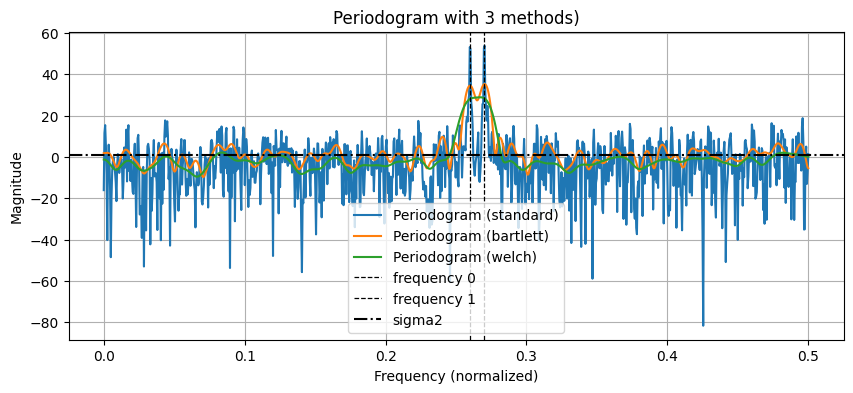

In [394]:
frequencies=[0.26,0.27]
sigma2=1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms(signal,frequencies)

Après les observation faites, on observe que le periodogramme est la methode avec la meilleure resolution, que ce soit en diminuant le SNR ou en diminuant la distance entre les 2 fréquences, on peut toujours discerner les 2 fréquences.

A l'inverse, la methode de Welsh donne une mauvaise résolution dans les 2 cas, lorsque la distance entre les 2 fréquences diminue, on ne discerne plus 2 fréquences distincts, et lorsque le SNR diminue, on a du mal à voir qu'il y a 2 fréquences. 

De la même manière la méthode de Bartlett est un peu plus intermediaire, on observe toujours 2 fréquences en diminuant la distance, mais on voit très bien qu'en diminuant un peu plus on ne pourra plus discerner, mais lorsqu'on diminue le SNR, on ne peut pas voir 2 frequences tant on a des pics a des fréquences differentes. 

Ainsi le periodogramme standart a la meilleure résolution alors que les méthodes de Bartlett et de Welsh ont une mauvaise résolution (l'une en augmantant le bruit, l'autre en rapprochant les 2 fréquences).

---

### Q4)

In [395]:
frequencies=[0.1,0.3]
sigma2=1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)

ar4_coeffs_estimate = librosa.lpc(signal, order=4)

print(ar4_coeffs_estimate)


[ 1.         -0.20068483  0.21319925 -0.2410837   0.1923978 ]


---

### Q5)

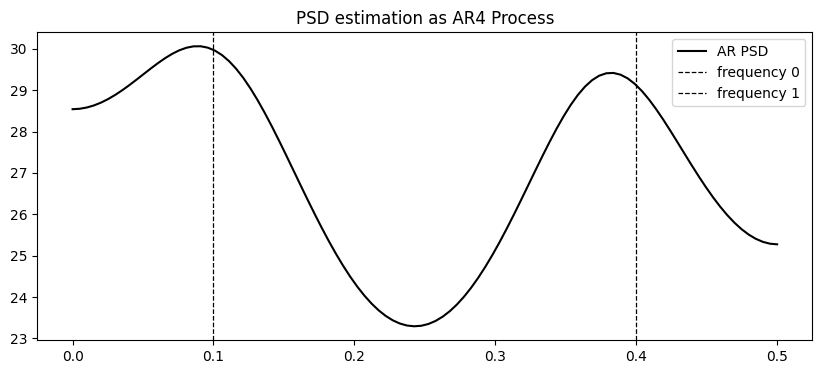

In [622]:
ar4_coeffs_estimate = librosa.lpc(signal, order=4)
ar_true=[]
for i in range (1,len(ar4_coeffs_estimate)):
    ar_true.append(-ar4_coeffs_estimate[i])
nus=np.linspace(0, 0.5, n)
psd=[]

for nu in nus:
    psd.append(10*np.log(ar_psd(ar_true,sigma2,nu)))
plt.figure(figsize=(10, 4))
plt.plot(nus, psd, label='AR PSD', color='black')
for i in range(len(frequencies)):
        plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
plt.legend()
plt.title('PSD estimation as AR4 Process')
plt.show()



In [620]:
#même fonction que précédemment en ajoutant l'estimation AR4
def show_periodograms2(signal,frequencies=[],L=8,overlap=0.5):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)

    #ajout:
    ar4_coeffs_estimate = librosa.lpc(signal, order=4)
    ar_true=[]
    for i in range (1,len(ar4_coeffs_estimate)):
        ar_true.append(-ar4_coeffs_estimate[i])
    psd=[]
    for nu in nus:
        psd.append(10*np.log(ar_psd(ar_true,sigma2,nu)))


    periodogram={'standard':[],'bartlett':[],'welch':[]}
    methodss=['standard','bartlett','welch']
    for methods in methodss:
        for nu in nus:
            periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
    plt.figure(figsize=(10, 4))
    plt.plot(nus, psd, label='AR PSD')
    for i in range(len(frequencies)):
        plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
    plt.title(f'Periodogram with 3 methods)')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
    for i in range(len(frequencies)):
        plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
    plt.plot(nus, psd, label='AR PSD')
    plt.axhline(sigma2, color='black', linestyle='-.', label='sigma2')
    plt.title(f'Periodogram with 4 methods)')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

SNR faible

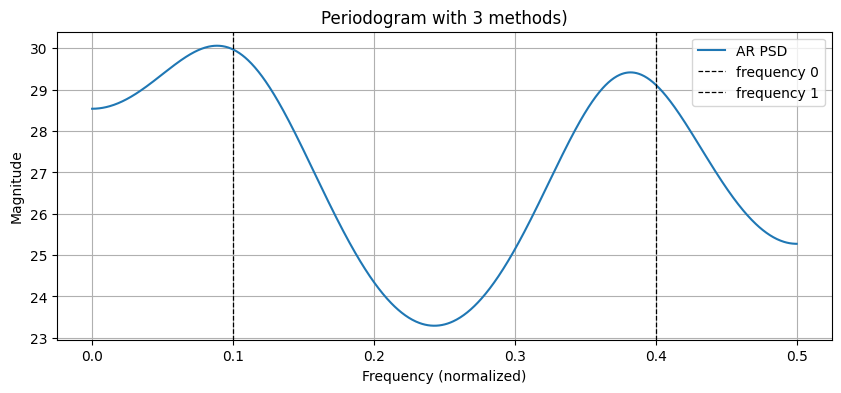

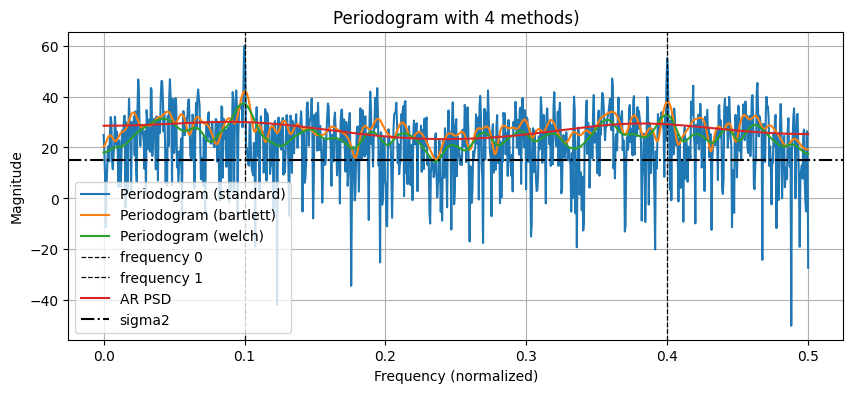

In [621]:
frequencies=[0.1,0.4]
sigma2=15
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms2(signal,frequencies)

SNR élevé

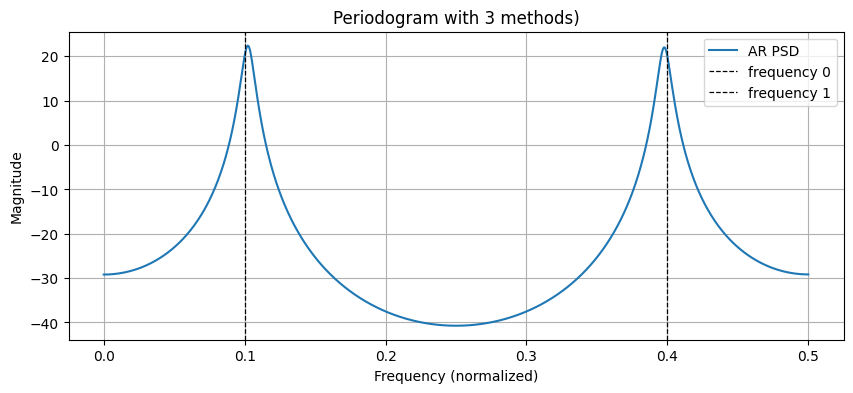

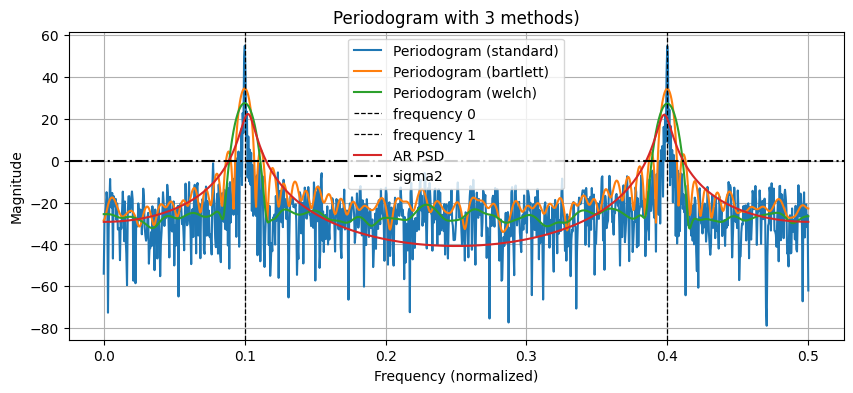

In [399]:
frequencies=[0.1,0.4]
sigma2=0.1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms2(signal,frequencies)

Fréquences proches

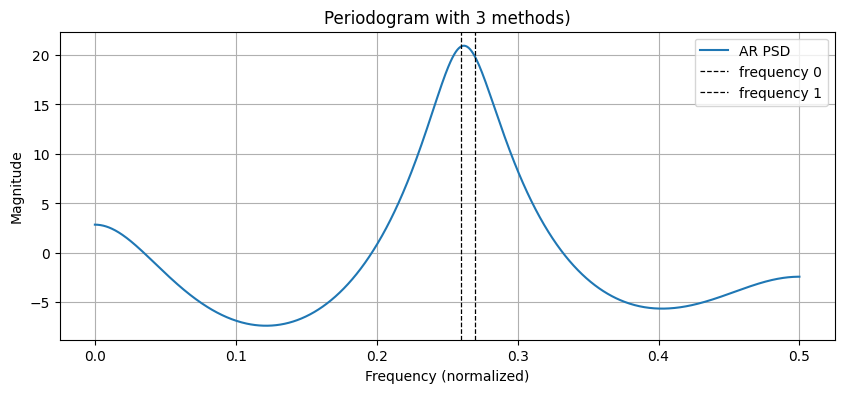

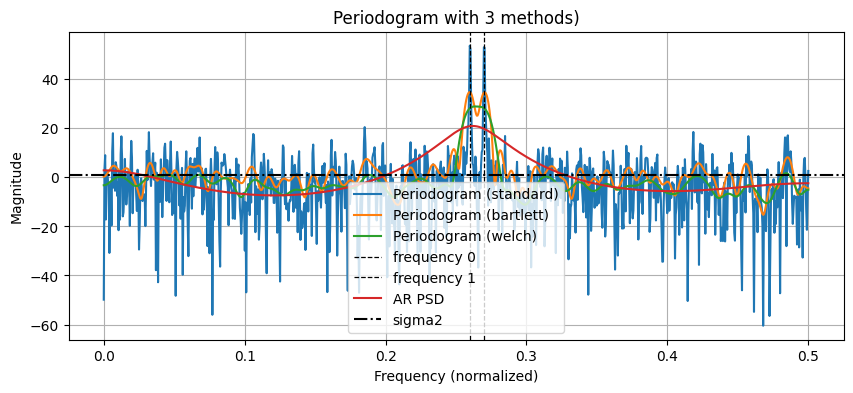

In [400]:
frequencies=[0.26,0.27]
sigma2=1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
show_periodograms2(signal,frequencies)

La méthode avec l'estimation d'un AR4 permet de séparer les fréquences avec peu de bruit, cependant dès que le bruit augmente et que les fréquences se rapprochent, on ne peut plus les discerner, ainsi cette méthode donne une mauvaise résolution.

---

 ### Q6)

In [442]:
def capon_estimator(signal, m=20):
    N = len(signal)
    
    #Covariance matrix
    X = np.array([signal[i:i+m] for i in range(N - m)])
    R = np.dot(X.T.conj(), X) / (N - m)
    R_inv = np.linalg.inv(R)
    psd = np.zeros(N)

    for i in range(N):
        w = np.exp(-2j * np.pi * i/N * np.arange(m))
        a = w[:, np.newaxis]
        psd[i] = 1.0 / np.real(np.dot(np.dot(a.conj().T, R_inv), a)).item()

    return psd

    

def capon_show(signal,frequencies=[]):
    N=len(signal)
    nus = np.linspace(0, 0.5, N//2 + 1)
    Pxx_capon = capon_estimator(signal)

    plt.figure(figsize=(10, 4))
    plt.plot(nus,Pxx_capon[:N//2 +1])
    for i in range(len(frequencies)):
        plt.axvline(frequencies[i], color='black', linestyle='--',linewidth=0.9, label=f'frequency {i}')
    plt.title('Capon Estimator')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

---

### Q7)

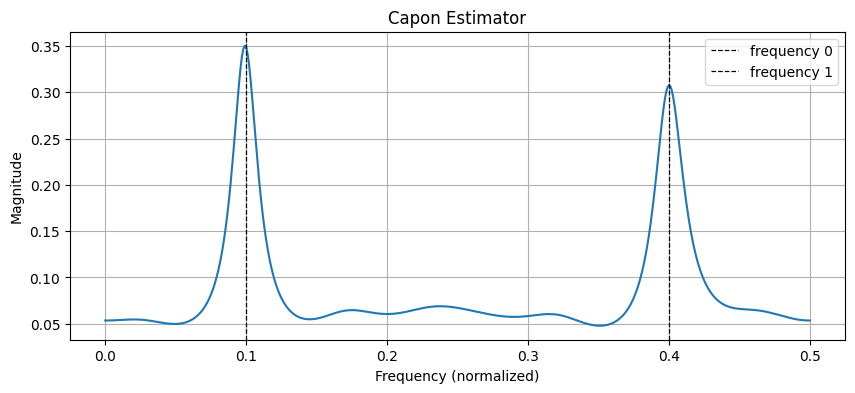

In [402]:
frequencies=[0.1,0.4]
sigma2=1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
capon_show(signal,frequencies)

SNR faible

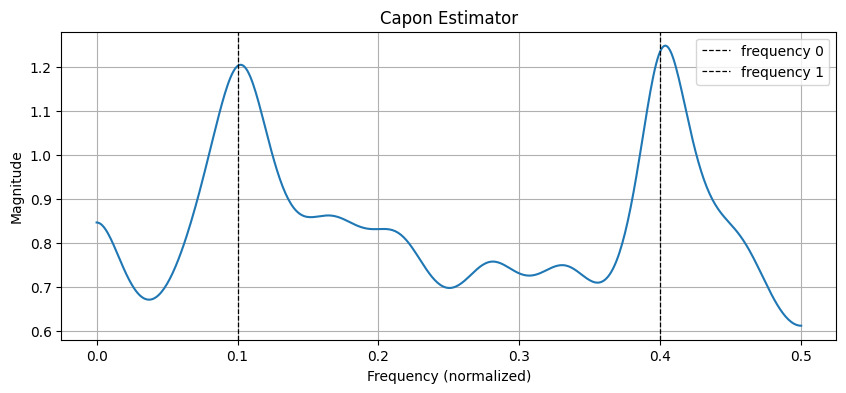

In [403]:
frequencies=[0.1,0.4]
sigma2=15
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
capon_show(signal,frequencies)

SNR élevé

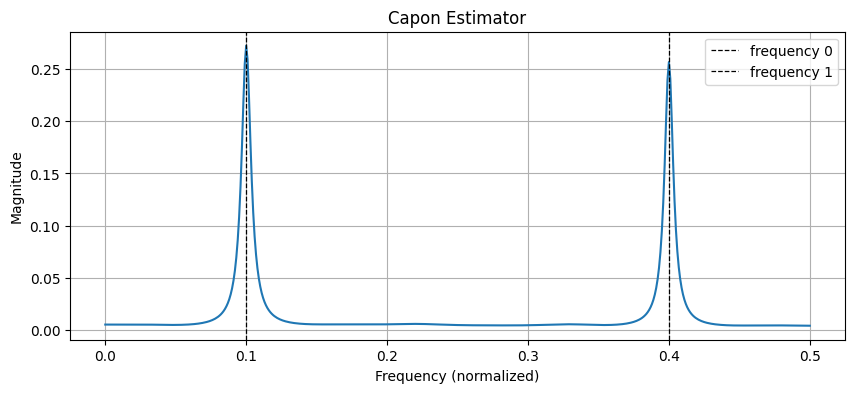

In [404]:
frequencies=[0.1,0.4]
sigma2=0.1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
capon_show(signal,frequencies)

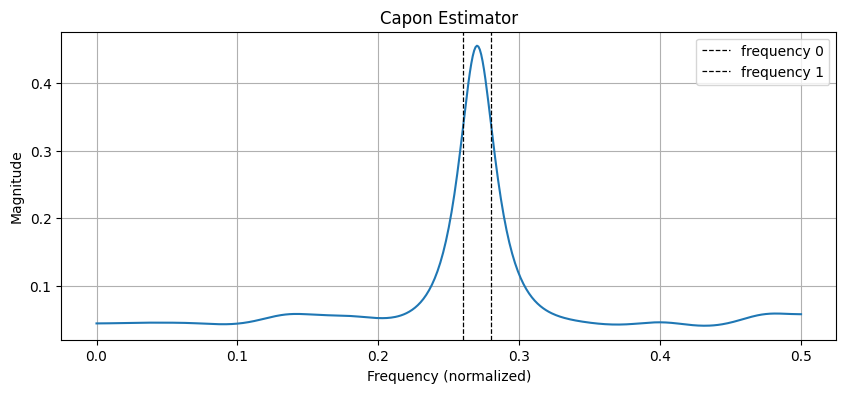

In [405]:
frequencies=[0.26,0.28]
sigma2=1
signal=synthetise_signal(N,K,frequencies,amplitudes,phases,sigma2)
capon_show(signal,frequencies)

L'estimateur de Capon peut être bien lorsque le bruit est élevé (SNR faible), cependant il n'est pas très bon pour séparer des fréquences proches, ainsi sa résolution est meilleur que l'estimation AR mais peut se valoir avec la méthode welsh (bonne gestion avec beaucoup de bruit mais mauvaise résolution lorsque 2 fréquences sont proches).

---
---

## PARTIE 3

### Q1)

In [406]:

def generate_arma_process(N, ar_coeffs, ma_coeffs, sigma2):

    noise = np.random.normal(0, np.sqrt(sigma2), size=N)  # Bruit blanc gaussien

    ar_coeffs = np.r_[1, -np.array(ar_coeffs)]  
    ma_coeffs = np.r_[1, np.array(ma_coeffs)] 

    # Génération du signal ARMA
    arma_process = lfilter(ma_coeffs, ar_coeffs, noise)

    return arma_process


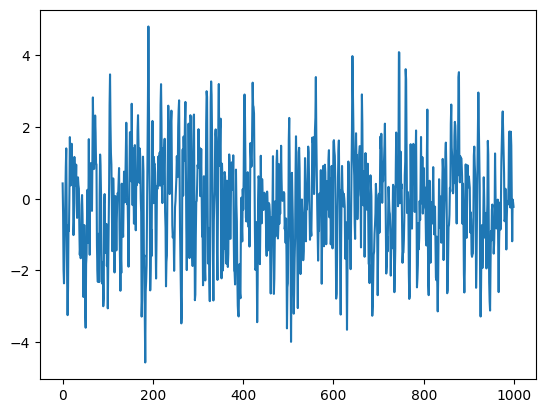

In [407]:
#Exemple :
N = 1000
ar_coeffs = [0.4]
ma_coeffs = [0.6]
sigma2 = 1

arma= generate_arma_process(N, ar_coeffs, ma_coeffs, sigma2)
plt.plot(arma)
plt.show()

---

### Q2)

Il nous suffit de reprendre les fonctions pour le ar :

In [429]:
#reprise de ar_psd
def arma_psd(ar_coeffs,ma_coeffs, sigma2, nu):

    p = len(ar_coeffs)
    q = len(ma_coeffs)
    numerator = sigma2 * np.abs(1 + np.sum([ma_coeffs[i] * np.exp(-2j * np.pi * nu * (i+1)) for i in range(q)], axis=0))**2
    denominator = np.abs(1 - np.sum([ar_coeffs[i] * np.exp(-2j * np.pi * nu * (i+1)) for i in range(p)], axis=0))**2
    return numerator / denominator

#reprise de show_periodogram_ar
def show_periodogram_arma(signal,methods,L=8,overlap=0.5,ar_coeffs=None,ma_coeffs=None):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)  
    if methods=='all':
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        methodss=['standard','bartlett','welch']
        psd=[]
        for nu in nus:
            for methods in methodss:
                periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
            psd.append(10*np.log(arma_psd(ar_coeffs,ma_coeffs, sigma2, nu)))
        plt.figure(figsize=(10, 4))
        for methods in methodss:
            plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')
        capon=capon_estimator(signal)
        plt.plot(np.linspace(0,0.5,N//2 +1), 10*np.log(capon[:N//2 +1]) +30, label='Capon Estimator')
        plt.plot(nus, psd, label='AR PSD', color='black', linestyle='--')
        plt.title('Periodogram and theoretical PSD')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.ylim(-60, 30)
        plt.grid()
        plt.legend()
        plt.show()

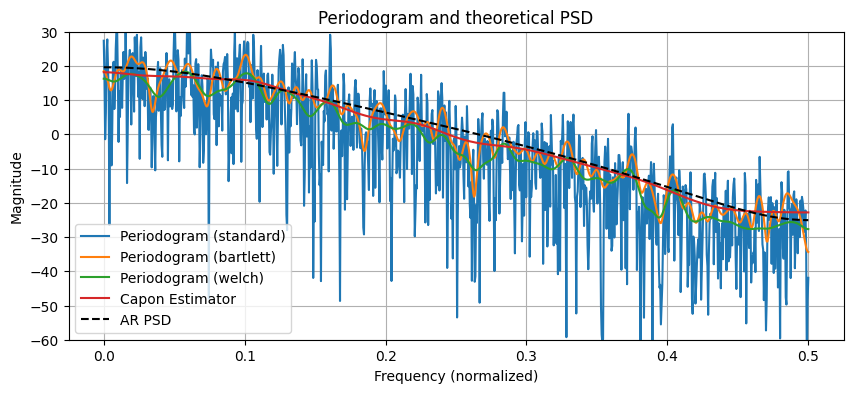

In [430]:
show_periodogram_arma(arma,'all',L=8,ar_coeffs=ar_coeffs,ma_coeffs=ma_coeffs)

On rajoute plus 30dB pour capon pour avoir une bonne comparaison .
On se rend compte que l'estimateur de Capon s'approche le plus du PSD réel tout en étant stable.

---

### Q3)
De même on reprend les fonctions de la partie 1 (qui ne sont pas du tout optimisées)

In [465]:

methodss=['standard','bartlett','welch']

def bias_calculator2(ar_coeffs,ma_coeffs,nu,n):
    periodogram={'standard':[],'bartlett':[],'welch':[]}
    for _ in range(n):
        arma_signal = generate_arma_process(N,ar_coeffs,ma_coeffs, sigma2)
        for methods in methodss:
            periodogram[methods].append(compute_periodogramm(arma_signal,nu,methods))

    V=[]
    for methods in methodss:
        V.append(np.mean(periodogram[methods]))
    return V

def bias_graph2(ar_coeffs,ma_coeffs,n):
    nus=np.linspace(0, 0.5, N)
    periodogram={'standard':[],'bartlett':[],'welch':[]}

    for nu in tqdm.tqdm(nus):
        for i in range(len(methodss)):
            periodogram[methodss[i]].append(bias_calculator2(ar_coeffs,ma_coeffs,nu,n)[i] - arma_psd(ar_coeffs,ma_coeffs,sigma2,nu))

    #Partie capon

    nus2=np.linspace(0, 0.5, N//2 + 1)
    Moy_capon=[]
    All_capon=[]
    for _ in range(n):
            arma_signal = generate_arma_process(N,ar_coeffs,ma_coeffs, sigma2)
            All_capon.append(capon_estimator(arma_signal)[:N//2 + 1])
    Moy_capon=np.mean(All_capon, axis=0)
    psd=[]
    for nu in nus2:
        psd.append(arma_psd(ar_coeffs,ma_coeffs,sigma2,nu))

    Bias_capon=Moy_capon - psd
    
    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus,periodogram[methods], label=f'Bias ({methods})')
    plt.plot(nus2,Bias_capon, label='capon')
    plt.title('Bias of Periodogram with 3 methods')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

def var_calculator2(ar_coeffs,ma_coeffs,nu,n):
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        for _ in range(n):
            ar_signal = generate_arma_process(N,ar_coeffs,ma_coeffs, sigma2)
            for methods in methodss:
                periodogram[methods].append(compute_periodogramm(ar_signal,nu,methods) - ar_psd(ar_coeffs,sigma2,nu))
        V=[]
        for methods in methodss:
            V.append(np.var(periodogram[methods]))
        return V
    
def var_graph2(ar_coeffs,ma_coeff,n):
    nus=np.linspace(0, 0.5, n)
    periodogram={'standard':[],'bartlett':[],'welch':[]}
    for nu in tqdm.tqdm(nus):
        for i in range(len(methodss)):
            periodogram[methodss[i]].append(var_calculator2(ar_coeffs,ma_coeffs,nu,n)[i])

    #Partie capon

    nus2=np.linspace(0, 0.5, N//2 + 1)
    Var_capon=[]
    All_capon=[]
    psd=[]
    for nu in nus2:
        psd.append(arma_psd(ar_coeffs,ma_coeffs,sigma2,nu))

    for _ in range(n):
            arma_signal = generate_arma_process(N,ar_coeffs,ma_coeffs, sigma2)
            All_capon.append(capon_estimator(arma_signal)[:N//2 + 1]-psd)
    Var_capon=np.var(All_capon, axis=0)

    plt.figure(figsize=(10, 4))
    for methods in methodss:
        plt.plot(nus,periodogram[methods], label=f'Variance ({methods})')
    plt.plot(nus2,Var_capon, label='capon')
    plt.title('Variance of Periodogram with 3 methods')
    plt.xlabel('Frequency (normalized)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.show()

100%|██████████| 200/200 [00:49<00:00,  4.07it/s]


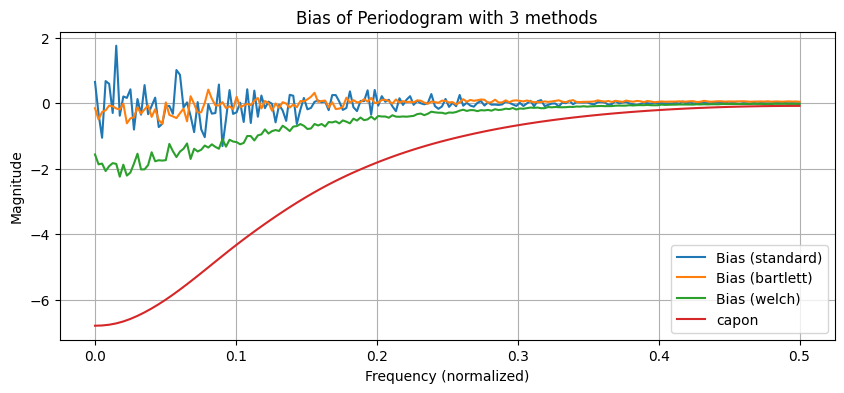

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


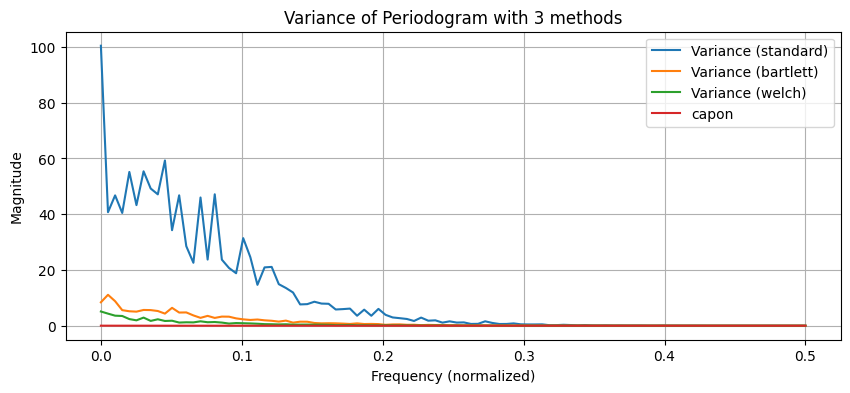

In [467]:
n=100
N=200
bias_graph2(ar_coeffs,ma_coeffs,n)
var_graph2(ar_coeffs,ma_coeffs,n)

On a dans l'ordre du meilleur au pire 

pour le biais : bartlett, standard, welch, capon
pour la variance : capon, welch, bartlett, standard

On remarque que la méthode de capon offre une encore meilleure variance que la méthode de welch, cependant le biais est le plus élevé.
Ainsi on comprend avec ces courbes et ce classement le compromis entre biais et variance (en augmentant le biais, on diminue la variance et inversement)

---


### Q4)

In [585]:

from scipy.linalg import toeplitz, solve_toeplitz
from statsmodels.tsa.stattools import acf

def estimate_ar_coeffs(acf_vals, p, q):
    """Étape 1 : estimation des coefficients AR via Yule-Walker modifié"""
    R = toeplitz(acf_vals[q:q + p])
    r = acf_vals[q + 1:q + p + 1]
    a = np.linalg.solve(R, r)
    return a

def compute_y_signal(X, a):
    """Étape 2 : calcul de Y_t = X_t - somme(a_k * X_{t-k})"""
    p = len(a)
    Y = np.zeros_like(X)
    for t in range(p, len(X)):
        Y[t] = X[t] - np.dot(a, X[t - p:t][::-1])
    return Y

def estimate_psd_from_acf(r, L):
    """Calcule la densité spectrale de puissance par DTFT tronquée"""
    k = np.arange(-L, L + 1)
    return lambda nu: np.sum(r[L + k] * np.exp(-2j * np.pi * nu * k))

def estimate_ma_coeffs_durbin(r_yy, q, L):
    """Étape 4-5 : estimation MA avec méthode de Durbin"""
    # Étape 4 : AR(L) sur r_yy
    R_L = toeplitz(r_yy[:L])
    a_L = np.linalg.solve(R_L, r_yy[1:L + 1])

    # Reconstituer r_L(k) = autocorr de A_L
    rL = np.zeros(2 * L + 1)
    for k in range(-L, L + 1):
        if k == 0:
            rL[L + k] = 1 + np.sum(a_L**2)
        elif abs(k) <= L:
            rL[L + k] = np.sum(a_L[:L - abs(k)] * a_L[abs(k):])
    
    # Étape 5 : AR(q) sur r_L(k)
    R_q = toeplitz(rL[L:L + q])
    r_q = rL[L + 1:L + q + 1]
    b = np.linalg.solve(R_q, r_q)

    return b  # b : coeffs MA

def durbin_arma_estimation(X, p, q, p_long):
    # Estimer l'ACF de X
    r_xx = acf(X, nlags=q + p + p_long, fft=True)

    # Étape 1
    a = estimate_ar_coeffs(r_xx, p, q)

    # Étape 2
    Y = compute_y_signal(X, a)

    # Étape 3 : Estimation de l'ACF de Y
    r_yy = acf(Y, nlags=p_long, fft=True)

    # Étape 4-5 : méthode de Durbin
    b = estimate_ma_coeffs_durbin(r_yy, q, p_long)

    return a, b


In [619]:
N = 1000
ar_coeffs = [0.6]
ma_coeffs = [0.4]
sigma2 = 1

arma= generate_arma_process(N, ar_coeffs, ma_coeffs, sigma2)

p, q, p_long = 1, 1, 5  # AR order, MA order, and long AR order
ar_est, ma_est = durbin_arma_estimation(arma, p, q, p_long)

print(ar_est,ma_est)

[0.67991539] [-0.04278278]


Le coefficient AR semble bien estimé mais pas celui MA

---

### Q5)

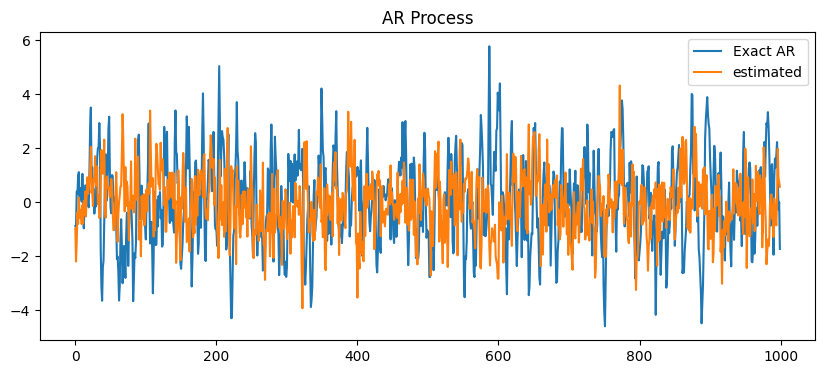

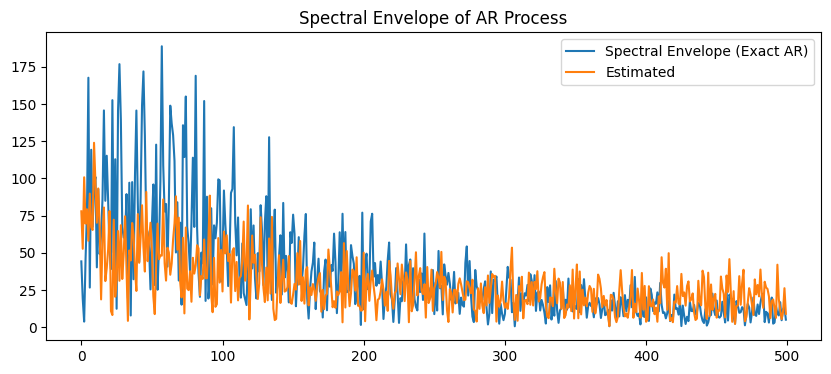

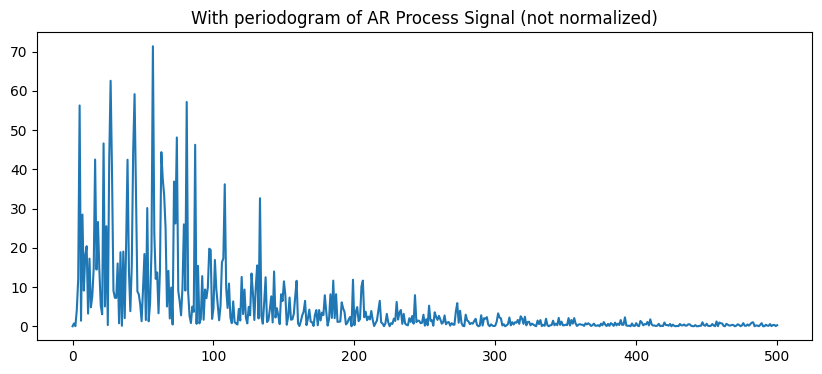

In [628]:
ar_coeffs = [0.6]
ma_coeffs = [0.4]
sigma2 = 1

arma= generate_arma_process(N, ar_coeffs, ma_coeffs, sigma2)
p, q, p_long = 1, 1, 10 # AR order, MA order, and long AR order
ar_est, ma_est = durbin_arma_estimation(arma, p, q, p_long)

arma_signal_estimate = generate_arma_process(N,ar_est,ma_est, sigma2)

plt.figure(figsize=(10, 4))
plt.plot(arma, label='Exact AR')
plt.plot(arma_signal_estimate, label='estimated')
plt.legend()
plt.title('AR Process')
plt.show()

fft_signal = np.fft.fft(arma)


envelope_spectral = np.abs(fft_signal)

plt.figure(figsize=(10, 4))
plt.plot(envelope_spectral[0:500], label='Spectral Envelope (Exact AR)')
plt.plot(np.abs(np.fft.fft(arma_signal_estimate))[0:500], label='Estimated')
plt.legend()
plt.title('Spectral Envelope of AR Process')
plt.show()

frequencies, Pxx = periodogram(arma)

plt.figure(figsize=(10, 4))
plt.plot( Pxx)
plt.title('With periodogram of AR Process Signal (not normalized)')
plt.show()

L'estimation de l'ARMA est moins bonne que celle de l'AR, cependant le résultat n'est pas abérrant non plus et les courbes ont la même forme, de même pour le periodogramme.

---

### Q6)

In [630]:
fs, data = wavfile.read("sounds/an_in_on.wav")

start_time = 0.15  # en secondes
duration = 0.3    # en secondes
start_sample = int(start_time * fs)
end_sample = int((start_time + duration) * fs)
segment_a = data[start_sample:end_sample]

In [645]:
def show_periodogram3(signal,methods,L=8,overlap=0.5):
    N=len(signal)
    nus = np.linspace(0, 0.5, N)  
    if methods=='all':
        periodogram={'standard':[],'bartlett':[],'welch':[]}
        methodss=['standard','bartlett','welch']
        for nu in nus:
            for methods in methodss:
                periodogram[methods].append(10*np.log(compute_periodogramm(signal,nu,methods,L=L,overlap=overlap)))
        plt.figure(figsize=(10, 4))
        for methods in methodss:
            plt.plot(nus, periodogram[methods], label=f'Periodogram ({methods})')

        #partie capon

        capon=capon_estimator(signal)
        plt.plot(np.linspace(0,0.5,N//2 +1), 10*np.log(np.abs(capon[:N//2 +1])) +30, label='Capon Estimator')

        #partie arma

        p, q, p_long = 1, 1, 10 # AR order, MA order, and long AR order
        ar_est, ma_est = durbin_arma_estimation(arma, p, q, p_long)
        psd=[]
        for nu in nus:
            psd.append(np.log(10*arma_psd(ar_est, ma_est,sigma2,nu)))
        plt.plot(nus, psd, label='estimation arma')
        
        
        plt.title(f'Periodogram of AR Process Signal with 3 methods')
        plt.xlabel('Frequency (normalized)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()
        plt.show()

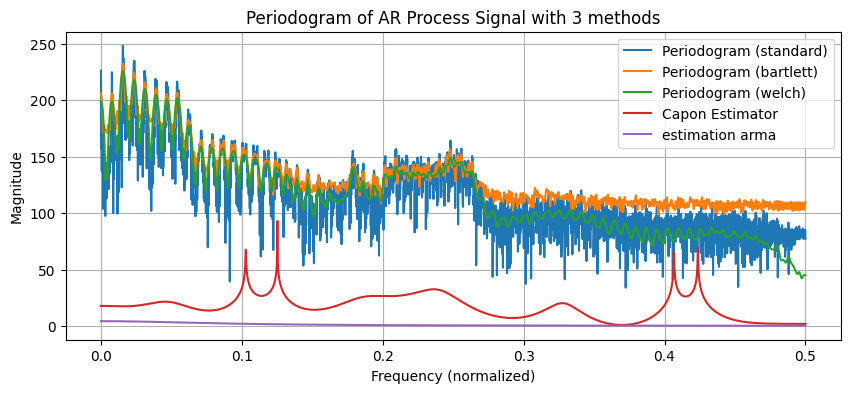

In [644]:
show_periodogram3(segment_a,'all')

La methods de Capon donne un résultat hazardeux et peu comprehensible, de plus l'estimation arma est aussi très mauvaise.